# 7 Building Final Model

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import r2_score
import shap

/Applications/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Applications/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

In [2]:
from PyTorch2Sklearn.MLP import MLP
from PyTorch2Sklearn.Transformer import Transformer
from PyTorch2Sklearn.MLP_AGNN import MLP_AGNN
from PyTorch2Sklearn.Transformer_AGNN import Transformer_AGNN
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import torch.nn as nn
from PyTorch2Sklearn.utils.data import TabularDataset, TabularDataFactory, GraphDataFactory
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
import warnings
warnings.simplefilter('ignore')

## Read in and Prepare Data

In [10]:
train_data = pd.read_csv('../data/curated/modelling/train.csv')
val_data = pd.read_csv('../data/curated/modelling/val.csv')
test_data = pd.read_csv('../data/curated/modelling/test.csv')

with open('../models/feature_importance_ordering.pickle', 'rb') as f:
    feature_importance_ordering = pickle.load(f)

In [11]:
import os
from collections import defaultdict as dd
manip_type = 'NormalisedData'

csv_list = os.listdir(f'../data/curated/{manip_type}')
csv_list.sort()

# Evaluation Functions

In [24]:
def get_game_321_score(ground_truth_votes, pred_votes):
    game_321_score = 0

    if ground_truth_votes['3'] == pred_votes['3']:
        game_321_score += 3
    elif ground_truth_votes['3'] == pred_votes['2']:
        game_321_score += 2
    elif ground_truth_votes['3'] == pred_votes['1']:
        game_321_score += 1

    if ground_truth_votes['2'] == pred_votes['3']:
        game_321_score += 1
    elif ground_truth_votes['2'] == pred_votes['2']:
        game_321_score += 2
    elif ground_truth_votes['2'] == pred_votes['1']:
        game_321_score += 1

    if ground_truth_votes['1'] == pred_votes['3']:
        game_321_score += 1/3
    elif ground_truth_votes['1'] == pred_votes['2']:
        game_321_score += 2/3
    elif ground_truth_votes['1'] == pred_votes['1']:
        game_321_score += 1

    return game_321_score

In [8]:
def eval(model, year, features, random=False, graph = False):

    tally = dd(int)
    game_321_score = 0
    game_count = 0

    for file in csv_list:
        if year in file:
            data = pd.read_csv(f'../data/curated/{manip_type}/{file}')
            
            if graph:
                data['idx'] = 0

            data = data.fillna(0)

            player = data['Player']
            if random:
                pred = np.random.normal(0, 1, len(data))
            else:
                pred = model.predict(
                    data[list(list(feature_importance_ordering.keys())[features])+['idx']] if graph \
                        else data[list(list(feature_importance_ordering.keys())[features])])
            pred = pd.DataFrame(
                {'player': player, 'predicted_score': pred})

            pred_votes = {
                '3': list(pred.sort_values('predicted_score', ascending=False)['player'])[0],
                '2': list(pred.sort_values('predicted_score', ascending=False)['player'])[1],
                '1': list(pred.sort_values('predicted_score', ascending=False)['player'])[2]
            }

            tally[pred_votes['3']] += 3
            tally[pred_votes['2']] += 2
            tally[pred_votes['1']] += 1

            if sum(data['Brownlow Votes']) != 0:
                ground_truth_votes = {
                    '3': data[data['Brownlow Votes'] == 3]['Player'].values[0],
                    '2': data[data['Brownlow Votes'] == 2]['Player'].values[0],
                    '1': data[data['Brownlow Votes'] == 1]['Player'].values[0],
                }

                game_321_score += get_game_321_score(
                    ground_truth_votes, pred_votes)
                game_count += 1

    tally_list = list(tally.items())
    tally_list.sort(key=lambda x: x[1], reverse=True)

    return tally_list, game_321_score/game_count, game_321_score, game_count

# Year-by-year backtest

In [9]:
def year_by_year_evaluation(model, features: str, graph=False):
    # get year by year evaluation (train with previous years, test on next years

    for test_year in range(2016, 2024):

        print(f'TRAIN YEARS: 2015 - {test_year - 1}')

        train_data = pd.DataFrame()
        
        game_id = 0
        for file in csv_list:
            file_year = int(file.split(' ')[0])
            if file_year < test_year:
                data = pd.read_csv('../data/curated/NormalisedData/' + file)

                if graph:
                    data['idx'] = game_id
                    game_id += 1
                
                train_data = pd.concat([train_data, data])

        train_data = train_data.fillna(0)

        model.fit(train_data[list(
            list(feature_importance_ordering.keys())[features])+['idx']] if graph else \
                train_data[list(
            list(feature_importance_ordering.keys())[features])], train_data[['target', 'idx']] if graph else \
                train_data['target'])

        for year in range(test_year, 2024):
            tally_list, game_321_score, game_321_score_total, game_count = eval(
                model, str(year), features, graph=graph)
            print(
                f'Year: {year}, Game 321 Score: {np.round(game_321_score, 2)}, Game Count: {game_count}')
            print(tally_list[:10])

        print('')

In [10]:
# MLP
params = {'hidden_dim': 16, 'hidden_layers': 3, 'dropout': 0, 'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'batchnorm': False, 'grad_clip': True, 'random_state': 42, 'loss': nn.MSELoss(), 'input_dim': 37, 'output_dim': 1, 'mode': 'Regression', 'verbose': True, 'TabularDataFactory': TabularDataFactory,
          'TabularDataset': TabularDataset, }
model = MLP(**params)

features = 36

year_by_year_evaluation(model, features)

TRAIN YEARS: 2015 - 2015


100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Year: 2016, Game 321 Score: 3.04, Game Count: 199
[('Patrick Dangerfield', 35), ('Dustin Martin', 29), ('Robbie Gray', 27), ('Scott Pendlebury', 25), ('Rory Sloane', 21), ('Adam Treloar', 21), ('Luke Shuey', 20), ('Heath Shaw', 20), ('Luke Parker', 19), ('Jack Steven', 19)]
Year: 2017, Game 321 Score: 3.07, Game Count: 200
[('Patrick Dangerfield', 41), ('Dustin Martin', 37), ('Rory Sloane', 31), ('Tom Mitchell', 28), ('Joshua Kelly', 22), ('Dayne Zorko', 21), ('Dayne Beams', 21), ('Zachary Merrett', 18), ('Nathan Fyfe', 18), ('Gary Ablett', 18)]
Year: 2018, Game 321 Score: 2.78, Game Count: 199
[('Tom Mitchell', 41), ('Brodie Grundy', 34), ('Clayton Oliver', 26), ('Nathan Fyfe', 22), ('Jackson Macrae', 22), ('Dayne Beams', 20), ('Patrick Dangerfield', 20), ('Dustin Martin', 18), ('Rory Laird', 17), ('Patrick Cripps', 17)]
Year: 2019, Game 321 Score: 3.06, Game Count: 199
[('Brodie Grundy', 31), ('Adam Treloar', 29), ('Patrick Dangerfield', 29), ('Nathan Fyfe', 28), ('Lachie Neale', 25)

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Year: 2017, Game 321 Score: 3.28, Game Count: 200
[('Patrick Dangerfield', 42), ('Dustin Martin', 37), ('Tom Mitchell', 37), ('Rory Sloane', 31), ('Dayne Beams', 22), ('Dayne Zorko', 21), ('Joshua Kelly', 21), ('Zachary Merrett', 18), ('Nathan Fyfe', 18), ('Sam Docherty', 17)]
Year: 2018, Game 321 Score: 2.88, Game Count: 199
[('Tom Mitchell', 43), ('Brodie Grundy', 42), ('Clayton Oliver', 27), ('Jackson Macrae', 25), ('Nathan Fyfe', 22), ('Patrick Cripps', 20), ('Patrick Dangerfield', 20), ('Max Gawn', 20), ('Dayne Beams', 19), ('Stephen Coniglio', 17)]
Year: 2019, Game 321 Score: 3.27, Game Count: 199
[('Patrick Dangerfield', 31), ('Nathan Fyfe', 31), ('Brodie Grundy', 30), ('Lachie Neale', 29), ('Adam Treloar', 29), ('Jackson Macrae', 26), ('Josh Dunkley', 24), ('Dayne Zorko', 19), ('Patrick Cripps', 19), ('Dustin Martin', 19)]
Year: 2020, Game 321 Score: 3.11, Game Count: 164
[('Lachie Neale', 30), ('Luke Parker', 22), ('Zachary Merrett', 20), ('Jack Steele', 20), ('Jackson Macrae'

100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Year: 2018, Game 321 Score: 3.0, Game Count: 199
[('Brodie Grundy', 41), ('Tom Mitchell', 39), ('Clayton Oliver', 27), ('Jackson Macrae', 24), ('Patrick Dangerfield', 23), ('Nathan Fyfe', 21), ('Patrick Cripps', 20), ('Max Gawn', 19), ('Joel Selwood', 18), ('Dayne Beams', 18)]
Year: 2019, Game 321 Score: 3.41, Game Count: 199
[('Brodie Grundy', 33), ('Patrick Dangerfield', 31), ('Nathan Fyfe', 28), ('Lachie Neale', 27), ('Adam Treloar', 25), ('Jackson Macrae', 21), ('Josh Dunkley', 21), ('Matt Crouch', 20), ('Dayne Zorko', 20), ('Travis Boak', 19)]
Year: 2020, Game 321 Score: 3.18, Game Count: 164
[('Lachie Neale', 28), ('Luke Parker', 22), ('Jack Steele', 21), ('Travis Boak', 20), ('Zachary Merrett', 20), ('Jackson Macrae', 18), ('Max Gawn', 18), ('Brodie Grundy', 17), ('Taylor Adams', 17), ('Patrick Dangerfield', 16)]
Year: 2021, Game 321 Score: 3.26, Game Count: 199
[('Jack Steele', 35), ('Oliver Wines', 34), ('Clayton Oliver', 31), ('Tom Mitchell', 29), ('Jackson Macrae', 27), ('Da

100%|██████████| 20/20 [00:59<00:00,  3.00s/it]


Year: 2019, Game 321 Score: 3.29, Game Count: 199
[('Brodie Grundy', 30), ('Patrick Dangerfield', 30), ('Lachie Neale', 29), ('Nathan Fyfe', 28), ('Jackson Macrae', 27), ('Adam Treloar', 23), ('Josh Dunkley', 22), ('Joshua Kelly', 20), ('Dayne Zorko', 19), ('Patrick Cripps', 19)]
Year: 2020, Game 321 Score: 3.14, Game Count: 164
[('Lachie Neale', 28), ('Jack Steele', 23), ('Luke Parker', 22), ('Zachary Merrett', 22), ('Jackson Macrae', 19), ('Taylor Adams', 16), ('Travis Boak', 16), ('Christian Petracca', 15), ('Cameron Guthrie', 15), ('Sam Menegola', 15)]
Year: 2021, Game 321 Score: 3.22, Game Count: 199
[('Tom Mitchell', 34), ('Oliver Wines', 31), ('Jack Steele', 30), ('Jackson Macrae', 28), ('Clayton Oliver', 27), ('Sam Walsh', 26), ('Darcy Parish', 25), ('Touk Miller', 25), ('Cameron Guthrie', 22), ('Zachary Merrett', 21)]
Year: 2022, Game 321 Score: 3.18, Game Count: 200
[('Lachie Neale', 30), ('Clayton Oliver', 30), ('Christian Petracca', 28), ('Andrew Brayshaw', 27), ('Rory Lair

100%|██████████| 20/20 [01:19<00:00,  3.95s/it]


Year: 2020, Game 321 Score: 3.17, Game Count: 164
[('Lachie Neale', 30), ('Luke Parker', 24), ('Jack Steele', 24), ('Patrick Dangerfield', 21), ('Travis Boak', 20), ('Zachary Merrett', 20), ('Jackson Macrae', 20), ('Taylor Adams', 17), ('Max Gawn', 17), ('Sam Menegola', 16)]
Year: 2021, Game 321 Score: 3.34, Game Count: 199
[('Tom Mitchell', 34), ('Oliver Wines', 32), ('Jack Steele', 32), ('Jackson Macrae', 30), ('Clayton Oliver', 30), ('Darcy Parish', 27), ('Touk Miller', 25), ('Sam Walsh', 24), ('Jarryd Lyons', 24), ('Brodie Grundy', 21)]
Year: 2022, Game 321 Score: 3.23, Game Count: 200
[('Lachie Neale', 34), ('Christian Petracca', 31), ('Clayton Oliver', 31), ('Rory Laird', 27), ('Andrew Brayshaw', 26), ('Patrick Cripps', 25), ('Zachary Merrett', 25), ('Josh Dunkley', 22), ('Sam Walsh', 20), ('Callum Mills', 20)]
Year: 2023, Game 321 Score: 2.65, Game Count: 212
[('Nick Daicos', 32), ('Christian Petracca', 29), ('Zak Butters', 28), ('Andrew Brayshaw', 26), ('Errol Gulden', 25), ('M

100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


Year: 2021, Game 321 Score: 3.35, Game Count: 199
[('Jack Steele', 33), ('Tom Mitchell', 32), ('Jackson Macrae', 30), ('Clayton Oliver', 30), ('Oliver Wines', 30), ('Darcy Parish', 26), ('Jarryd Lyons', 24), ('Brodie Grundy', 24), ('Touk Miller', 24), ('Marcus Bontempelli', 22)]
Year: 2022, Game 321 Score: 3.24, Game Count: 200
[('Lachie Neale', 33), ('Clayton Oliver', 31), ('Christian Petracca', 29), ('Rory Laird', 25), ('Andrew Brayshaw', 24), ('Patrick Cripps', 24), ('Zachary Merrett', 24), ('Sam Walsh', 20), ('Josh Dunkley', 20), ('Callum Mills', 20)]
Year: 2023, Game 321 Score: 2.61, Game Count: 212
[('Nick Daicos', 31), ('Christian Petracca', 28), ('Marcus Bontempelli', 28), ('Zak Butters', 27), ('Andrew Brayshaw', 26), ('Errol Gulden', 25), ('Caleb Serong', 23), ('Rory Laird', 22), ('Tim Taranto', 21), ('Tom Green', 20)]

TRAIN YEARS: 2015 - 2021


100%|██████████| 20/20 [02:21<00:00,  7.06s/it]


Year: 2022, Game 321 Score: 3.17, Game Count: 200
[('Clayton Oliver', 33), ('Lachie Neale', 32), ('Christian Petracca', 30), ('Zachary Merrett', 26), ('Rory Laird', 26), ('Andrew Brayshaw', 24), ('Patrick Cripps', 23), ('Josh Dunkley', 21), ('Touk Miller', 20), ('Sam Walsh', 20)]
Year: 2023, Game 321 Score: 2.59, Game Count: 212
[('Nick Daicos', 31), ('Marcus Bontempelli', 29), ('Christian Petracca', 28), ('Andrew Brayshaw', 26), ('Zak Butters', 26), ('Errol Gulden', 26), ('Caleb Serong', 23), ('Rory Laird', 23), ('Lachie Neale', 22), ('Jordan Dawson', 22)]

TRAIN YEARS: 2015 - 2022


100%|██████████| 20/20 [02:31<00:00,  7.58s/it]


Year: 2023, Game 321 Score: 2.63, Game Count: 212
[('Nick Daicos', 31), ('Christian Petracca', 29), ('Zak Butters', 28), ('Andrew Brayshaw', 26), ('Marcus Bontempelli', 26), ('Errol Gulden', 25), ('Caleb Serong', 23), ('Tim Taranto', 21), ('Noah Anderson', 21), ('Connor Rozee', 20)]



In [21]:
# GBR
model = GradientBoostingRegressor(learning_rate=0.01,
                                      n_estimators=800,
                                      subsample=0.25,
                                      max_features=0.7,
                                      min_samples_split=64,
                                      max_depth=96,
                                      random_state=42)
featues = 36

year_by_year_evaluation(model, features)

TRAIN YEARS: 2015 - 2015
1194
Year: 2016, Game 321 Score: 2.99, Game Count: 199
[('Patrick Dangerfield', 44), ('Robbie Gray', 27), ('Scott Pendlebury', 26), ('Rory Sloane', 25), ('Adam Treloar', 25), ('Stephen Coniglio', 23), ('Dustin Martin', 23), ('Luke Parker', 21), ('Joel Selwood', 21), ('Zachary Merrett', 20)]
1200
Year: 2017, Game 321 Score: 3.11, Game Count: 200
[('Patrick Dangerfield', 36), ('Dustin Martin', 34), ('Tom Mitchell', 32), ('Rory Sloane', 31), ('Gary Ablett', 20), ('Dayne Zorko', 20), ('Joshua Kelly', 20), ('Zachary Merrett', 19), ('Adam Treloar', 19), ('Taylor Adams', 19)]
1194
Year: 2018, Game 321 Score: 2.7, Game Count: 199
[('Tom Mitchell', 38), ('Brodie Grundy', 34), ('Jackson Macrae', 29), ('Clayton Oliver', 25), ('Dayne Beams', 21), ('Patrick Dangerfield', 20), ('Nathan Fyfe', 19), ('Josh P. Kennedy', 19), ('Joel Selwood', 18), ('Stephen Coniglio', 17)]
1194
Year: 2019, Game 321 Score: 3.01, Game Count: 199
[('Patrick Dangerfield', 27), ('Nathan Fyfe', 25), (

In [18]:
# Transformer
params = {'hidden_dim': 16, 'num_transformer_layers': 2, 'num_mlp_layers': 1, 'dropout': 0.1, 'batch_size': 128, 'nhead': 4, 'share_embedding_mlp': True, 'use_cls': False, 'epochs': 10, 'lr': 0.01, 'batchnorm': False, 'grad_clip': False, 'random_state': 42, 'loss': nn.MSELoss(), 'input_dim': 15, 'output_dim': 1, 'mode': 'Regression', 'verbose': True, 'TabularDataFactory': TabularDataFactory,
          'TabularDataset': TabularDataset, }

model = Transformer(**params)
features = 14

year_by_year_evaluation(model, features)

TRAIN YEARS: 2015 - 2015


100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


Year: 2016, Game 321 Score: 2.81, Game Count: 199
[('Patrick Dangerfield', 33), ('Robbie Gray', 24), ('Bryce Gibbs', 24), ('Scott Pendlebury', 24), ('Zachary Merrett', 24), ('Rory Sloane', 22), ('Joel Selwood', 22), ('Adam Treloar', 21), ('Stephen Coniglio', 21), ('Luke Shuey', 20)]
Year: 2017, Game 321 Score: 2.88, Game Count: 200
[('Dustin Martin', 37), ('Patrick Dangerfield', 36), ('Rory Sloane', 30), ('Dayne Zorko', 22), ('Zachary Merrett', 21), ('Sebastian Ross', 21), ('Tom Mitchell', 21), ('Dayne Beams', 20), ('Gary Ablett', 19), ('Joshua Kelly', 19)]
Year: 2018, Game 321 Score: 2.56, Game Count: 199
[('Tom Mitchell', 31), ('Brodie Grundy', 31), ('Jackson Macrae', 27), ('Patrick Dangerfield', 23), ('Clayton Oliver', 22), ('Dayne Beams', 21), ('Stephen Coniglio', 20), ('Max Gawn', 20), ('Nathan Fyfe', 18), ('Bryce Gibbs', 15)]
Year: 2019, Game 321 Score: 2.87, Game Count: 199
[('Brodie Grundy', 30), ('Nathan Fyfe', 29), ('Patrick Dangerfield', 28), ('Joshua Kelly', 23), ('Adam Tre

100%|██████████| 10/10 [01:53<00:00, 11.31s/it]


Year: 2017, Game 321 Score: 2.77, Game Count: 200
[('Patrick Dangerfield', 33), ('Dustin Martin', 30), ('Rory Sloane', 30), ('Zachary Merrett', 21), ('Joshua Kelly', 21), ('Dayne Zorko', 21), ('Dayne Beams', 20), ('Marcus Bontempelli', 20), ('Tom Mitchell', 19), ('Scott Pendlebury', 18)]
Year: 2018, Game 321 Score: 2.48, Game Count: 199
[('Brodie Grundy', 35), ('Tom Mitchell', 26), ('Patrick Dangerfield', 24), ('Jackson Macrae', 23), ('Clayton Oliver', 23), ('Max Gawn', 22), ('Stephen Coniglio', 18), ('Callum Sinclair', 18), ('Nathan Fyfe', 17), ('Todd Goldstein', 16)]
Year: 2019, Game 321 Score: 2.62, Game Count: 199
[('Brodie Grundy', 34), ('Nathan Fyfe', 26), ('Patrick Dangerfield', 25), ('Max Gawn', 23), ('Dayne Zorko', 21), ('Joshua Kelly', 20), ('Jarryd Lyons', 20), ('Josh Dunkley', 19), ('Luke Parker', 19), ('Elliot Yeo', 18)]
Year: 2020, Game 321 Score: 2.37, Game Count: 164
[('Max Gawn', 26), ('Todd Goldstein', 25), ('Brodie Grundy', 24), ('Luke Parker', 22), ('Jack Steele', 2

100%|██████████| 10/10 [02:58<00:00, 17.86s/it]


Year: 2018, Game 321 Score: 2.8, Game Count: 199
[('Tom Mitchell', 34), ('Clayton Oliver', 27), ('Patrick Dangerfield', 26), ('Brodie Grundy', 25), ('Nathan Fyfe', 24), ('Jackson Macrae', 24), ('Dayne Beams', 22), ('Joel Selwood', 20), ('Dustin Martin', 17), ('Sebastian Ross', 17)]
Year: 2019, Game 321 Score: 3.13, Game Count: 199
[('Nathan Fyfe', 32), ('Patrick Dangerfield', 31), ('Brodie Grundy', 25), ('Lachie Neale', 23), ('Jackson Macrae', 21), ('Dayne Zorko', 20), ('Jarryd Lyons', 20), ('Patrick Cripps', 19), ('Adam Treloar', 19), ('Marcus Bontempelli', 19)]
Year: 2020, Game 321 Score: 2.85, Game Count: 164
[('Lachie Neale', 30), ('Luke Parker', 23), ('Patrick Dangerfield', 23), ('Jack Steele', 20), ('Zachary Merrett', 18), ('Travis Boak', 16), ('Jackson Macrae', 16), ('Max Gawn', 16), ('Taylor Adams', 15), ('Dylan Shiel', 14)]
Year: 2021, Game 321 Score: 3.1, Game Count: 199
[('Jack Steele', 35), ('Oliver Wines', 29), ('Touk Miller', 27), ('Marcus Bontempelli', 26), ('Jarryd Lyon

100%|██████████| 10/10 [04:04<00:00, 24.48s/it]


Year: 2019, Game 321 Score: 3.09, Game Count: 199
[('Patrick Dangerfield', 31), ('Nathan Fyfe', 31), ('Marcus Bontempelli', 25), ('Joshua Kelly', 24), ('Brodie Grundy', 24), ('Travis Boak', 22), ('Jackson Macrae', 22), ('Lachie Neale', 21), ('Patrick Cripps', 21), ('Adam Treloar', 21)]
Year: 2020, Game 321 Score: 2.81, Game Count: 164
[('Lachie Neale', 32), ('Luke Parker', 22), ('Jack Steele', 22), ('Patrick Dangerfield', 22), ('Travis Boak', 20), ('Dylan Shiel', 17), ('Taylor Adams', 17), ('Jackson Macrae', 17), ('Sam Menegola', 17), ('Christian Petracca', 16)]
Year: 2021, Game 321 Score: 3.22, Game Count: 199
[('Jack Steele', 37), ('Oliver Wines', 34), ('Marcus Bontempelli', 30), ('Jackson Macrae', 27), ('Touk Miller', 27), ('Tom Mitchell', 25), ('Clayton Oliver', 25), ('Jarryd Lyons', 25), ('Darcy Parish', 25), ('Sam Walsh', 24)]
Year: 2022, Game 321 Score: 2.9, Game Count: 200
[('Touk Miller', 33), ('Christian Petracca', 30), ('Clayton Oliver', 27), ('Lachie Neale', 26), ('Rory Lai

100%|██████████| 10/10 [04:40<00:00, 28.09s/it]


Year: 2020, Game 321 Score: 2.73, Game Count: 164
[('Lachie Neale', 31), ('Jack Steele', 22), ('Luke Parker', 21), ('Max Gawn', 21), ('Patrick Dangerfield', 20), ('Zachary Merrett', 19), ('Travis Boak', 18), ('Todd Goldstein', 18), ('Andrew Gaff', 16), ('Jackson Macrae', 16)]
Year: 2021, Game 321 Score: 3.07, Game Count: 199
[('Jack Steele', 34), ('Jackson Macrae', 31), ('Tom Mitchell', 29), ('Darcy Parish', 27), ('Oliver Wines', 27), ('Clayton Oliver', 26), ('Touk Miller', 26), ('Brodie Grundy', 25), ('Marcus Bontempelli', 25), ('Sam Walsh', 23)]
Year: 2022, Game 321 Score: 2.79, Game Count: 200
[('Christian Petracca', 27), ('Touk Miller', 27), ('Andrew Brayshaw', 26), ('Lachie Neale', 26), ('Rory Laird', 25), ('Callum Mills', 24), ('Zachary Merrett', 23), ('Clayton Oliver', 22), ('Patrick Cripps', 21), ('Josh Dunkley', 21)]
Year: 2023, Game 321 Score: 2.24, Game Count: 212
[('Marcus Bontempelli', 32), ('Andrew Brayshaw', 27), ('Jordan Dawson', 27), ('Christian Petracca', 27), ('Nick 

100%|██████████| 10/10 [04:30<00:00, 27.06s/it]


Year: 2021, Game 321 Score: 3.2, Game Count: 199
[('Jack Steele', 35), ('Oliver Wines', 34), ('Touk Miller', 30), ('Marcus Bontempelli', 29), ('Tom Mitchell', 28), ('Jackson Macrae', 27), ('Clayton Oliver', 26), ('Darcy Parish', 26), ('Rory Laird', 25), ('Sam Walsh', 25)]
Year: 2022, Game 321 Score: 2.89, Game Count: 200
[('Touk Miller', 32), ('Clayton Oliver', 30), ('Christian Petracca', 29), ('Lachie Neale', 26), ('Rory Laird', 25), ('Andrew Brayshaw', 24), ('Patrick Cripps', 24), ('Zachary Merrett', 24), ('Callum Mills', 24), ('Darcy Parish', 20)]
Year: 2023, Game 321 Score: 2.36, Game Count: 212
[('Marcus Bontempelli', 34), ('Christian Petracca', 30), ('Andrew Brayshaw', 28), ('Zachary Merrett', 26), ('Jordan Dawson', 26), ('Nick Daicos', 24), ('Zak Butters', 24), ('Noah Anderson', 23), ('Caleb Serong', 22), ('Rowan Marshall', 22)]

TRAIN YEARS: 2015 - 2021


100%|██████████| 10/10 [04:39<00:00, 27.95s/it]


Year: 2022, Game 321 Score: 2.92, Game Count: 200
[('Christian Petracca', 28), ('Andrew Brayshaw', 26), ('Touk Miller', 26), ('Lachie Neale', 25), ('Clayton Oliver', 25), ('Rory Laird', 23), ('Callum Mills', 23), ('Zachary Merrett', 22), ('Patrick Cripps', 21), ('Josh Dunkley', 21)]
Year: 2023, Game 321 Score: 2.22, Game Count: 212
[('Marcus Bontempelli', 32), ('Andrew Brayshaw', 27), ('Jordan Dawson', 26), ('Christian Petracca', 26), ('Rowan Marshall', 24), ('Zachary Merrett', 22), ('Josh Dunkley', 21), ('Zak Butters', 21), ('Luke D-Uniacke', 20), ('Errol Gulden', 20)]

TRAIN YEARS: 2015 - 2022


100%|██████████| 10/10 [06:36<00:00, 39.62s/it]


Year: 2023, Game 321 Score: 2.29, Game Count: 212
[('Marcus Bontempelli', 35), ('Rowan Marshall', 28), ('Andrew Brayshaw', 27), ('Jordan Dawson', 26), ('Christian Petracca', 26), ('Zachary Merrett', 25), ('Rory Laird', 24), ('Josh Dunkley', 22), ('Caleb Serong', 22), ('Tim Taranto', 21)]



In [7]:
# XGB
model = XGBRegressor(**{
        'random_state': 19260817,
        'n_jobs': -1,
        'n_estimators': 400, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.55, 'gamma': 1e-06, 'eta': 0.1
    })

features = 19

year_by_year_evaluation(model, features)

TRAIN YEARS: 2015 - 2015
Year: 2016, Game 321 Score: 2.73, Game Count: 199
[('Patrick Dangerfield', 48), ('Robbie Gray', 26), ('Scott Pendlebury', 25), ('Dustin Martin', 24), ('Joel Selwood', 23), ('Zachary Merrett', 22), ('Adam Treloar', 20), ('Lachie Neale', 20), ('Bryce Gibbs', 19), ('Luke Parker', 19)]
Year: 2017, Game 321 Score: 2.73, Game Count: 200
[('Patrick Dangerfield', 35), ('Dustin Martin', 33), ('Rory Sloane', 28), ('Tom Mitchell', 27), ('Dayne Zorko', 24), ('Gary Ablett', 20), ('Joshua Kelly', 20), ('Matt Crouch', 19), ('Zachary Merrett', 19), ('Taylor Adams', 19)]
Year: 2018, Game 321 Score: 2.57, Game Count: 199
[('Tom Mitchell', 40), ('Clayton Oliver', 33), ('Brodie Grundy', 31), ('Jackson Macrae', 28), ('Nathan Fyfe', 22), ('Patrick Dangerfield', 22), ('Dayne Beams', 20), ('Lachie Neale', 19), ('Elliot Yeo', 18), ('Stephen Coniglio', 16)]
Year: 2019, Game 321 Score: 2.76, Game Count: 199
[('Patrick Dangerfield', 32), ('Nathan Fyfe', 28), ('Patrick Cripps', 26), ('Jack

In [25]:
# Linear Regression
model = LinearRegression(**{'fit_intercept': True,
                                })
features = 36

year_by_year_evaluation(model, features)

TRAIN YEARS: 2015 - 2015
1194
Year: 2016, Game 321 Score: 2.94, Game Count: 199
[('Patrick Dangerfield', 36), ('Robbie Gray', 27), ('Scott Pendlebury', 26), ('Dustin Martin', 25), ('Lachie Neale', 25), ('Luke Shuey', 21), ('Rory Sloane', 20), ('Stephen Coniglio', 20), ('Adam Treloar', 20), ('Luke Parker', 19)]
1200
Year: 2017, Game 321 Score: 2.94, Game Count: 200
[('Patrick Dangerfield', 38), ('Dustin Martin', 37), ('Rory Sloane', 31), ('Tom Mitchell', 28), ('Joshua Kelly', 23), ('Dayne Zorko', 20), ('Dayne Beams', 20), ('Zachary Merrett', 19), ('Clayton Oliver', 19), ('Gary Ablett', 18)]
1194
Year: 2018, Game 321 Score: 2.62, Game Count: 199
[('Tom Mitchell', 38), ('Brodie Grundy', 35), ('Clayton Oliver', 30), ('Nathan Fyfe', 24), ('Jackson Macrae', 24), ('Patrick Dangerfield', 20), ('Dayne Beams', 19), ('Max Gawn', 18), ('Sebastian Ross', 17), ('Rory Laird', 16)]
1194
Year: 2019, Game 321 Score: 2.95, Game Count: 199
[('Adam Treloar', 29), ('Nathan Fyfe', 29), ('Brodie Grundy', 29),

In [14]:
# Random Baseline

for year in range(2016, 2024):
    tally_list, game_321_score, game_321_score_total, game_count = eval(
        None, str(year), None, random=True)
    print(
        f'Year: {year}, Game 321 Score: {np.round(game_321_score, 2)}, Game Count: {game_count}')
    print(tally_list[:10])

Year: 2016, Game 321 Score: 0.3, Game Count: 199
[('Shaun Grigg', 11), ('Travis Boak', 10), ('Lachlan Hunter', 10), ('Ben McEvoy', 9), ('Tom Lynch', 9), ('Ryan Bastinac', 9), ('Zach Tuohy', 8), ('Brandon Matera', 8), ('Rory Laird', 8), ('Danyle Pearce', 8)]
Year: 2017, Game 321 Score: 0.28, Game Count: 200
[('Billy Longer', 14), ('David Astbury', 11), ('Jared Polec', 11), ('Jack Sinclair', 10), ('Tom McDonald', 9), ('Patrick Dangerfield', 9), ('Blake Acres', 9), ('Matthew Rosa', 8), ('Sam Gibson', 8), ('Jack Steele', 8)]
Year: 2018, Game 321 Score: 0.31, Game Count: 199
[('Harry Cunningham', 11), ('James Frawley', 10), ('Paul Seedsman', 9), ('Shaun Atley', 9), ('Scott Pendlebury', 9), ('Jack Graham', 8), ('Tom Lynch', 8), ('Jack Billings', 8), ('Alex Pearce', 8), ('Max Gawn', 8)]
Year: 2019, Game 321 Score: 0.24, Game Count: 199
[('Karl Amon', 14), ('Kane Lambert', 12), ('Jacob Hopper', 11), ('Jarrod Harbrow', 11), ('Brayden Fiorini', 10), ('Brodie Smith', 10), ('Matthew De Boer', 9), 

In [25]:
# Linear Regression
model = MLP_AGNN(**{'hidden_dim': 16, 'num_encoder_layers': 2, 'num_decoder_layers': 1, 'num_graph_layers': 2, 'graph_nhead': 8, 'dropout': 0, 'epochs': 15, 'lr': 0.001, 'batchnorm': False, 'grad_clip': True, 'random_state': 42,
                    'loss': nn.MSELoss(),
                    'rootpath': './',
                    'GraphDataFactory': GraphDataFactory,
                    'output_dim': 1,
                    'mode': 'Regression',
                    'verbose': True, 'input_dim': 37})
features = 36

year_by_year_evaluation(model, features, graph=True)

TRAIN YEARS: 2015 - 2015


100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


Year: 2016, Game 321 Score: 3.08, Game Count: 199
[('Patrick Dangerfield', 38), ('Robbie Gray', 25), ('Scott Pendlebury', 25), ('Dustin Martin', 24), ('Tom Lynch', 23), ('Joshua Kennedy', 21), ('Luke Shuey', 20), ('Joel Selwood', 20), ('Adam Treloar', 20), ('Luke Parker', 19)]
Year: 2017, Game 321 Score: 3.18, Game Count: 200
[('Dustin Martin', 40), ('Patrick Dangerfield', 38), ('Rory Sloane', 30), ('Lance Franklin', 21), ('Joshua Kelly', 21), ('Marcus Bontempelli', 21), ('Tom Mitchell', 20), ('Dayne Zorko', 19), ('Dayne Beams', 19), ('Zachary Merrett', 18)]
Year: 2018, Game 321 Score: 2.76, Game Count: 199
[('Tom Mitchell', 37), ('Brodie Grundy', 34), ('Clayton Oliver', 24), ('Patrick Dangerfield', 24), ('Lance Franklin', 21), ('Nathan Fyfe', 21), ('Jackson Macrae', 21), ('Max Gawn', 20), ('Patrick Cripps', 18), ('Dustin Martin', 17)]
Year: 2019, Game 321 Score: 3.03, Game Count: 199
[('Patrick Dangerfield', 33), ('Nathan Fyfe', 30), ('Brodie Grundy', 30), ('Lachie Neale', 23), ('Josh

100%|██████████| 15/15 [00:51<00:00,  3.42s/it]


Year: 2017, Game 321 Score: 3.4, Game Count: 200
[('Patrick Dangerfield', 42), ('Dustin Martin', 36), ('Tom Mitchell', 33), ('Rory Sloane', 31), ('Joshua Kelly', 23), ('Zachary Merrett', 22), ('Dayne Beams', 21), ('Dayne Zorko', 19), ('Marcus Bontempelli', 19), ('Nathan Fyfe', 19)]
Year: 2018, Game 321 Score: 2.95, Game Count: 199
[('Tom Mitchell', 39), ('Clayton Oliver', 30), ('Patrick Dangerfield', 26), ('Jackson Macrae', 26), ('Brodie Grundy', 25), ('Nathan Fyfe', 21), ('Dayne Beams', 20), ('Elliot Yeo', 20), ('Joel Selwood', 19), ('Stephen Coniglio', 18)]
Year: 2019, Game 321 Score: 3.35, Game Count: 199
[('Patrick Dangerfield', 31), ('Nathan Fyfe', 30), ('Adam Treloar', 26), ('Brodie Grundy', 26), ('Lachie Neale', 25), ('Jackson Macrae', 24), ('Joshua Kelly', 22), ('Dayne Zorko', 21), ('Travis Boak', 20), ('Josh Dunkley', 20)]
Year: 2020, Game 321 Score: 3.12, Game Count: 164
[('Lachie Neale', 31), ('Luke Parker', 24), ('Jackson Macrae', 23), ('Patrick Dangerfield', 23), ('Zachary

100%|██████████| 15/15 [01:20<00:00,  5.34s/it]


Year: 2018, Game 321 Score: 3.06, Game Count: 199
[('Brodie Grundy', 36), ('Tom Mitchell', 34), ('Patrick Dangerfield', 25), ('Clayton Oliver', 25), ('Jackson Macrae', 24), ('Nathan Fyfe', 22), ('Dustin Martin', 20), ('Dayne Beams', 20), ('Patrick Cripps', 19), ('Lance Franklin', 19)]
Year: 2019, Game 321 Score: 3.4, Game Count: 199
[('Patrick Dangerfield', 32), ('Brodie Grundy', 32), ('Nathan Fyfe', 30), ('Jackson Macrae', 25), ('Adam Treloar', 24), ('Lachie Neale', 23), ('Dayne Zorko', 20), ('Josh Dunkley', 20), ('Matt Crouch', 19), ('Dustin Martin', 19)]
Year: 2020, Game 321 Score: 3.2, Game Count: 164
[('Lachie Neale', 27), ('Luke Parker', 22), ('Taylor Adams', 20), ('Jackson Macrae', 20), ('Travis Boak', 19), ('Jack Steele', 19), ('Zachary Merrett', 18), ('Tom Hawkins', 18), ('Patrick Dangerfield', 17), ('Christian Petracca', 16)]
Year: 2021, Game 321 Score: 3.34, Game Count: 199
[('Jack Steele', 39), ('Oliver Wines', 33), ('Tom Mitchell', 27), ('Jackson Macrae', 26), ('Clayton Ol

100%|██████████| 15/15 [01:45<00:00,  7.01s/it]


Year: 2019, Game 321 Score: 3.39, Game Count: 199
[('Brodie Grundy', 35), ('Patrick Dangerfield', 33), ('Nathan Fyfe', 29), ('Jackson Macrae', 24), ('Lachie Neale', 23), ('Adam Treloar', 23), ('Matt Crouch', 20), ('Dayne Zorko', 20), ('Josh Dunkley', 19), ('Dustin Martin', 19)]
Year: 2020, Game 321 Score: 3.14, Game Count: 164
[('Lachie Neale', 30), ('Luke Parker', 23), ('Zachary Merrett', 21), ('Jackson Macrae', 20), ('Taylor Adams', 19), ('Max Gawn', 19), ('Brodie Grundy', 18), ('Patrick Dangerfield', 18), ('Travis Boak', 17), ('Tom Hawkins', 17)]
Year: 2021, Game 321 Score: 3.27, Game Count: 199
[('Jack Steele', 33), ('Tom Mitchell', 32), ('Oliver Wines', 30), ('Jackson Macrae', 26), ('Clayton Oliver', 26), ('Brodie Grundy', 26), ('Sam Walsh', 24), ('Marcus Bontempelli', 24), ('Darcy Parish', 21), ('Touk Miller', 21)]
Year: 2022, Game 321 Score: 3.25, Game Count: 200
[('Lachie Neale', 30), ('Christian Petracca', 29), ('Clayton Oliver', 27), ('Patrick Cripps', 25), ('Andrew Brayshaw'

100%|██████████| 15/15 [02:09<00:00,  8.67s/it]


Year: 2020, Game 321 Score: 3.16, Game Count: 164
[('Lachie Neale', 30), ('Luke Parker', 25), ('Jack Steele', 22), ('Jackson Macrae', 21), ('Zachary Merrett', 20), ('Travis Boak', 18), ('Patrick Dangerfield', 18), ('Andrew Gaff', 17), ('Taylor Adams', 17), ('Tom Hawkins', 16)]
Year: 2021, Game 321 Score: 3.43, Game Count: 199
[('Jack Steele', 38), ('Tom Mitchell', 37), ('Oliver Wines', 37), ('Jackson Macrae', 27), ('Clayton Oliver', 27), ('Darcy Parish', 26), ('Marcus Bontempelli', 26), ('Touk Miller', 25), ('Sam Walsh', 24), ('Christian Petracca', 24)]
Year: 2022, Game 321 Score: 3.3, Game Count: 200
[('Lachie Neale', 32), ('Clayton Oliver', 29), ('Christian Petracca', 28), ('Rory Laird', 27), ('Patrick Cripps', 26), ('Andrew Brayshaw', 25), ('Zachary Merrett', 24), ('Touk Miller', 22), ('Josh Dunkley', 22), ('Jeremy Cameron', 20)]
Year: 2023, Game 321 Score: 2.81, Game Count: 212
[('Andrew Brayshaw', 28), ('Marcus Bontempelli', 28), ('Nick Daicos', 27), ('Tim Taranto', 27), ('Zak But

100%|██████████| 15/15 [02:31<00:00, 10.10s/it]


Year: 2021, Game 321 Score: 3.39, Game Count: 199
[('Tom Mitchell', 34), ('Jack Steele', 34), ('Jackson Macrae', 33), ('Oliver Wines', 30), ('Clayton Oliver', 29), ('Darcy Parish', 29), ('Marcus Bontempelli', 25), ('Jarryd Lyons', 23), ('Sam Walsh', 22), ('Touk Miller', 22)]
Year: 2022, Game 321 Score: 3.26, Game Count: 200
[('Lachie Neale', 30), ('Christian Petracca', 30), ('Rory Laird', 27), ('Clayton Oliver', 26), ('Patrick Cripps', 25), ('Zachary Merrett', 22), ('Andrew Brayshaw', 21), ('Touk Miller', 20), ('Sam Walsh', 20), ('Jeremy Cameron', 20)]
Year: 2023, Game 321 Score: 2.74, Game Count: 212
[('Nick Daicos', 31), ('Christian Petracca', 30), ('Andrew Brayshaw', 25), ('Zak Butters', 25), ('Errol Gulden', 24), ('Caleb Serong', 23), ('Marcus Bontempelli', 23), ('Rory Laird', 21), ('Lachie Neale', 20), ('Rowan Marshall', 20)]

TRAIN YEARS: 2015 - 2021


100%|██████████| 15/15 [02:56<00:00, 11.80s/it]


Year: 2022, Game 321 Score: 3.27, Game Count: 200
[('Lachie Neale', 31), ('Christian Petracca', 30), ('Clayton Oliver', 29), ('Patrick Cripps', 26), ('Rory Laird', 26), ('Zachary Merrett', 24), ('Andrew Brayshaw', 22), ('Touk Miller', 22), ('Callum Mills', 21), ('Josh Dunkley', 20)]
Year: 2023, Game 321 Score: 2.73, Game Count: 212
[('Christian Petracca', 31), ('Nick Daicos', 29), ('Zak Butters', 27), ('Andrew Brayshaw', 25), ('Marcus Bontempelli', 24), ('Tim Taranto', 23), ('Caleb Serong', 23), ('Rory Laird', 23), ('Errol Gulden', 23), ('Lachie Neale', 22)]

TRAIN YEARS: 2015 - 2022


100%|██████████| 15/15 [03:21<00:00, 13.43s/it]


Year: 2023, Game 321 Score: 2.97, Game Count: 212
[('Christian Petracca', 31), ('Nick Daicos', 29), ('Marcus Bontempelli', 26), ('Tim Taranto', 25), ('Andrew Brayshaw', 24), ('Errol Gulden', 24), ('Toby Greene', 23), ('Caleb Serong', 23), ('Zak Butters', 23), ('Rory Laird', 22)]



In [26]:
# Linear Regression
model = Transformer_AGNN(**{'hidden_dim': 16, 'num_transformer_layers': 1, 'num_graph_layers': 1, 'num_mlp_layers': 1, 'graph_nhead': 8, 'dropout': 0, 'nhead': 4, 'share_embedding_mlp': False, 'use_cls': False, 'epochs': 20, 'lr': 0.001, 'batchnorm': False, 'grad_clip': False, 'random_state': 42,
                            'loss': nn.MSELoss(),
                            'rootpath': './',
                            'GraphDataFactory': GraphDataFactory,
                            'output_dim': 1,
                            'mode': 'Regression',
                            'verbose': True, 'input_dim': 37})
features = 36

year_by_year_evaluation(model, features, graph=True)

TRAIN YEARS: 2015 - 2015


100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


Year: 2016, Game 321 Score: 3.21, Game Count: 199
[('Patrick Dangerfield', 44), ('Dustin Martin', 31), ('Robbie Gray', 30), ('Lachie Neale', 26), ('Stephen Coniglio', 26), ('Scott Pendlebury', 24), ('Joel Selwood', 23), ('Adam Treloar', 23), ('Matthew Priddis', 22), ('Luke Shuey', 21)]
Year: 2017, Game 321 Score: 3.28, Game Count: 200
[('Patrick Dangerfield', 46), ('Dustin Martin', 40), ('Tom Mitchell', 35), ('Rory Sloane', 30), ('Joshua Kelly', 24), ('Taylor Adams', 23), ('Sebastian Ross', 22), ('Dayne Beams', 22), ('Nathan Fyfe', 21), ('Dayne Zorko', 21)]
Year: 2018, Game 321 Score: 2.93, Game Count: 199
[('Tom Mitchell', 37), ('Clayton Oliver', 29), ('Brodie Grundy', 29), ('Patrick Cripps', 24), ('Jackson Macrae', 24), ('Nathan Fyfe', 23), ('Patrick Dangerfield', 23), ('Josh P. Kennedy', 21), ('Dustin Martin', 20), ('Dayne Beams', 20)]
Year: 2019, Game 321 Score: 3.25, Game Count: 199
[('Patrick Dangerfield', 31), ('Nathan Fyfe', 29), ('Adam Treloar', 28), ('Lachie Neale', 27), ('Br

100%|██████████| 20/20 [03:09<00:00,  9.45s/it]


Year: 2017, Game 321 Score: 3.3, Game Count: 200
[('Patrick Dangerfield', 40), ('Dustin Martin', 37), ('Rory Sloane', 30), ('Tom Mitchell', 29), ('Lance Franklin', 21), ('Joshua Kelly', 21), ('Dayne Zorko', 19), ('Dayne Beams', 19), ('Zachary Merrett', 17), ('Nathan Fyfe', 17)]
Year: 2018, Game 321 Score: 3.08, Game Count: 199
[('Brodie Grundy', 43), ('Tom Mitchell', 37), ('Clayton Oliver', 22), ('Patrick Dangerfield', 21), ('Jackson Macrae', 21), ('Max Gawn', 20), ('Nathan Fyfe', 18), ('Dustin Martin', 17), ('Dayne Beams', 17), ('Andrew Gaff', 17)]
Year: 2019, Game 321 Score: 3.19, Game Count: 199
[('Brodie Grundy', 33), ('Patrick Dangerfield', 28), ('Nathan Fyfe', 26), ('Jackson Macrae', 23), ('Dayne Zorko', 22), ('Lachie Neale', 22), ('Josh Dunkley', 19), ('Jarryd Lyons', 19), ('Dustin Martin', 19), ('Max Gawn', 18)]
Year: 2020, Game 321 Score: 3.12, Game Count: 164
[('Lachie Neale', 28), ('Luke Parker', 22), ('Brodie Grundy', 21), ('Jack Steele', 21), ('Zachary Merrett', 20), ('Pat

100%|██████████| 20/20 [04:41<00:00, 14.09s/it]


Year: 2018, Game 321 Score: 3.04, Game Count: 199
[('Brodie Grundy', 41), ('Tom Mitchell', 40), ('Jackson Macrae', 30), ('Clayton Oliver', 26), ('Patrick Dangerfield', 24), ('Max Gawn', 21), ('Lachie Neale', 21), ('Nathan Fyfe', 21), ('Patrick Cripps', 20), ('Dustin Martin', 17)]
Year: 2019, Game 321 Score: 3.43, Game Count: 199
[('Brodie Grundy', 35), ('Nathan Fyfe', 31), ('Patrick Dangerfield', 29), ('Adam Treloar', 26), ('Jackson Macrae', 26), ('Lachie Neale', 24), ('Matt Crouch', 21), ('Josh Dunkley', 21), ('Jarryd Lyons', 20), ('Dayne Zorko', 19)]
Year: 2020, Game 321 Score: 3.08, Game Count: 164
[('Lachie Neale', 30), ('Luke Parker', 25), ('Jack Steele', 21), ('Travis Boak', 20), ('Brodie Grundy', 20), ('Jackson Macrae', 19), ('Patrick Dangerfield', 19), ('Max Gawn', 19), ('Taylor Adams', 18), ('Christian Petracca', 18)]
Year: 2021, Game 321 Score: 3.38, Game Count: 199
[('Jack Steele', 36), ('Jackson Macrae', 34), ('Clayton Oliver', 32), ('Oliver Wines', 32), ('Tom Mitchell', 29

100%|██████████| 20/20 [06:18<00:00, 18.92s/it]


Year: 2019, Game 321 Score: 3.45, Game Count: 199
[('Patrick Dangerfield', 32), ('Brodie Grundy', 28), ('Adam Treloar', 27), ('Nathan Fyfe', 27), ('Lachie Neale', 25), ('Jackson Macrae', 23), ('Dustin Martin', 22), ('Josh Dunkley', 21), ('Travis Boak', 20), ('Matt Crouch', 19)]
Year: 2020, Game 321 Score: 3.06, Game Count: 164
[('Lachie Neale', 31), ('Luke Parker', 25), ('Jack Steele', 22), ('Jackson Macrae', 22), ('Sam Menegola', 21), ('Patrick Dangerfield', 21), ('Travis Boak', 19), ('Taylor Adams', 18), ('Zachary Merrett', 18), ('Andrew Gaff', 17)]
Year: 2021, Game 321 Score: 3.49, Game Count: 199
[('Jackson Macrae', 40), ('Oliver Wines', 35), ('Clayton Oliver', 34), ('Jack Steele', 31), ('Jarryd Lyons', 29), ('Tom Mitchell', 28), ('Darcy Parish', 26), ('Touk Miller', 26), ('Sam Walsh', 25), ('Marcus Bontempelli', 24)]
Year: 2022, Game 321 Score: 3.3, Game Count: 200
[('Lachie Neale', 31), ('Christian Petracca', 30), ('Clayton Oliver', 29), ('Rory Laird', 27), ('Patrick Cripps', 24)

100%|██████████| 20/20 [07:56<00:00, 23.81s/it]


Year: 2020, Game 321 Score: 3.2, Game Count: 164
[('Lachie Neale', 31), ('Luke Parker', 25), ('Travis Boak', 21), ('Jack Steele', 20), ('Taylor Adams', 19), ('Christian Petracca', 19), ('Jackson Macrae', 19), ('Andrew Gaff', 18), ('Patrick Dangerfield', 18), ('Max Gawn', 18)]
Year: 2021, Game 321 Score: 3.59, Game Count: 199
[('Jackson Macrae', 36), ('Oliver Wines', 36), ('Clayton Oliver', 35), ('Jack Steele', 35), ('Jarryd Lyons', 30), ('Darcy Parish', 25), ('Tom Mitchell', 24), ('Sam Walsh', 24), ('Touk Miller', 24), ('Christian Petracca', 23)]
Year: 2022, Game 321 Score: 3.33, Game Count: 200
[('Lachie Neale', 33), ('Clayton Oliver', 31), ('Rory Laird', 29), ('Christian Petracca', 28), ('Andrew Brayshaw', 24), ('Patrick Cripps', 24), ('Zachary Merrett', 24), ('Callum Mills', 23), ('Touk Miller', 18), ('Jeremy Cameron', 18)]
Year: 2023, Game 321 Score: 2.84, Game Count: 212
[('Christian Petracca', 31), ('Rory Laird', 30), ('Marcus Bontempelli', 30), ('Nick Daicos', 28), ('Caleb Seron

100%|██████████| 20/20 [09:15<00:00, 27.75s/it]


Year: 2021, Game 321 Score: 3.37, Game Count: 199
[('Jackson Macrae', 37), ('Jack Steele', 34), ('Oliver Wines', 33), ('Clayton Oliver', 30), ('Tom Mitchell', 28), ('Jarryd Lyons', 28), ('Darcy Parish', 25), ('Rory Laird', 23), ('Max Gawn', 22), ('Sam Walsh', 22)]
Year: 2022, Game 321 Score: 3.36, Game Count: 200
[('Lachie Neale', 32), ('Christian Petracca', 28), ('Clayton Oliver', 26), ('Rory Laird', 26), ('Patrick Cripps', 24), ('Andrew Brayshaw', 21), ('Touk Miller', 20), ('Jeremy Cameron', 20), ('Callum Mills', 20), ('Oliver Wines', 19)]
Year: 2023, Game 321 Score: 2.84, Game Count: 212
[('Christian Petracca', 31), ('Rory Laird', 29), ('Marcus Bontempelli', 27), ('Nick Daicos', 26), ('Zak Butters', 25), ('Rowan Marshall', 24), ('Tim Taranto', 23), ('Lachie Neale', 23), ('Caleb Serong', 23), ('Andrew Brayshaw', 22)]

TRAIN YEARS: 2015 - 2021


100%|██████████| 20/20 [10:43<00:00, 32.18s/it]


Year: 2022, Game 321 Score: 3.38, Game Count: 200
[('Lachie Neale', 31), ('Christian Petracca', 31), ('Clayton Oliver', 28), ('Rory Laird', 23), ('Patrick Cripps', 21), ('Andrew Brayshaw', 20), ('Zachary Merrett', 20), ('Jeremy Cameron', 19), ('Callum Mills', 19), ('Touk Miller', 18)]
Year: 2023, Game 321 Score: 2.91, Game Count: 212
[('Nick Daicos', 32), ('Christian Petracca', 32), ('Rory Laird', 27), ('Marcus Bontempelli', 27), ('Zak Butters', 26), ('Lachie Neale', 25), ('Tim Taranto', 23), ('Errol Gulden', 23), ('Caleb Serong', 22), ('Andrew Brayshaw', 21)]

TRAIN YEARS: 2015 - 2022


100%|██████████| 20/20 [12:19<00:00, 36.96s/it]


Year: 2023, Game 321 Score: 2.86, Game Count: 212
[('Nick Daicos', 33), ('Christian Petracca', 31), ('Rory Laird', 28), ('Marcus Bontempelli', 28), ('Tim Taranto', 25), ('Lachie Neale', 25), ('Errol Gulden', 25), ('Rowan Marshall', 23), ('Zak Butters', 23), ('Andrew Brayshaw', 22)]



## Train Models

### Fixed Transformer-AGNN (replicate tuning)

In [ ]:
graph_train = pd.read_csv('../data/curated/modelling/graph_train.csv')
graph_val = pd.read_csv('../data/curated/modelling/graph_val.csv')
graph_test = pd.read_csv('../data/curated/modelling/graph_test.csv')

In [ ]:
fixed_tfagnn = Transformer_AGNN(**{'hidden_dim': 16, 'num_transformer_layers': 1, 'num_graph_layers': 1, 'num_mlp_layers': 1, 'graph_nhead': 8, 'dropout': 0, 'nhead': 4, 'share_embedding_mlp': False, 'use_cls': False, 'epochs': 20, 'lr': 0.001, 'batchnorm': False, 'grad_clip': False, 'random_state': 42,
                                   'loss': nn.MSELoss(),
                                   'rootpath': './',
                                   'GraphDataFactory': GraphDataFactory,
                                   'output_dim': 1,
                                   'mode': 'Regression',
                                   'verbose': True, 'input_dim': 37})
fixed_tfagnn.fit(graph_train[list(list(feature_importance_ordering.keys())[
    36])+['idx']], graph_train[['target', 'idx']])

100%|██████████| 20/20 [10:32<00:00, 31.61s/it]


In [ ]:
tfagnn_pred = fixed_tfagnn.predict(
    graph_val[list(list(feature_importance_ordering.keys())[36])+['idx']])
r2_score(val_data['target'], tfagnn_pred)

0.9140664251035205

In [ ]:
with open('../models/final_models/fixed_tfagnn.pickle', 'wb') as f:
    pickle.dump(fixed_tfagnn, f)

### Continuously Retrained Transformer-AGNN

In [ ]:
params = {**{'hidden_dim': 16, 'num_transformer_layers': 1, 'num_graph_layers': 1, 'num_mlp_layers': 1, 'graph_nhead': 8, 'dropout': 0, 'nhead': 4, 'share_embedding_mlp': False, 'use_cls': False, 'epochs': 20, 'lr': 0.001, 'batchnorm': False, 'grad_clip': False, 'random_state': 42,
             'loss': nn.MSELoss(),
             'rootpath': './',
             'GraphDataFactory': GraphDataFactory,
             'output_dim': 1,
             'mode': 'Regression',
             'verbose': True, 'input_dim': 37}}

THIS_YEAR = 2024
up_to_date_train_data = pd.DataFrame()

game_id = 0
for file in csv_list:
    file_year = int(file.split(' ')[0])
    if file_year < THIS_YEAR:
        data = pd.read_csv('../data/curated/NormalisedData/' + file)

        data['idx'] = game_id

        game_id += 1

        up_to_date_train_data = pd.concat([up_to_date_train_data, data])


up_to_date_train_data = up_to_date_train_data.fillna(0)

retrain_tfagnn = Transformer_AGNN(**params)
retrain_tfagnn.fit(up_to_date_train_data[list(list(feature_importance_ordering.keys())[
    36])+['idx']], up_to_date_train_data[['target', 'idx']])

100%|██████████| 20/20 [15:57<00:00, 47.85s/it]


In [ ]:
with open('../models/final_models/retrain_tfagnn.pickle', 'wb') as f:
    pickle.dump(retrain_tfagnn, f)

### Fixed MLP (replicate tuning) (- best non-graph; for SHAP purposes)

In [ ]:
params = {'hidden_dim': 16, 'hidden_layers': 3, 'dropout': 0, 'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'batchnorm': False, 'grad_clip': True, 'random_state': 42, 'loss': nn.MSELoss(), 'input_dim': 37, 'output_dim': 1, 'mode': 'Regression', 'verbose': True, 'TabularDataFactory': TabularDataFactory,
          'TabularDataset': TabularDataset, }

fixed_mlp = MLP(**params)
fixed_mlp.fit(train_data[list(list(feature_importance_ordering.keys())[
    36])], train_data['target'])

In [20]:
mlp_pred = fixed_mlp.predict(train_data[list(list(feature_importance_ordering.keys())[
    36])])
r2_score(train_data['target'], mlp_pred)

0.907457404459572

In [21]:
with open('../models/final_models/fixed_mlp.pickle', 'wb') as f:
    pickle.dump(fixed_mlp, f)

### Continuously Retrained MLP (- best non-graph; for SHAP purposes)

In [ ]:
params = {'hidden_dim': 16, 'hidden_layers': 3, 'dropout': 0, 'batch_size': 16, 'epochs': 20, 'lr': 0.0001, 'batchnorm': False, 'grad_clip': True, 'random_state': 42, 'loss': nn.MSELoss(), 'input_dim': 37, 'output_dim': 1, 'mode': 'Regression', 'verbose': True, 'TabularDataFactory': TabularDataFactory,
          'TabularDataset': TabularDataset, }

THIS_YEAR = 2024
up_to_date_train_data = pd.DataFrame()
for file in csv_list:
    file_year = int(file.split(' ')[0])
    if file_year < THIS_YEAR:
        data = pd.read_csv('../data/curated/NormalisedData/' + file)

        up_to_date_train_data = pd.concat([up_to_date_train_data, data])

up_to_date_train_data = up_to_date_train_data.fillna(0)

retrain_mlp = MLP(**params)
retrain_mlp.fit(up_to_date_train_data[list(list(feature_importance_ordering.keys())[
    36])], up_to_date_train_data['target'])

In [23]:
with open('../models/final_models/retrain_mlp.pickle', 'wb') as f:
    pickle.dump(retrain_mlp, f)

# SHAP (Non-Graph Only)

In [24]:
with open('../models/final_models/fixed_mlp.pickle', 'rb') as f:
    fixed_mlp = pickle.load(f)

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/250 [00:00<?, ?it/s]

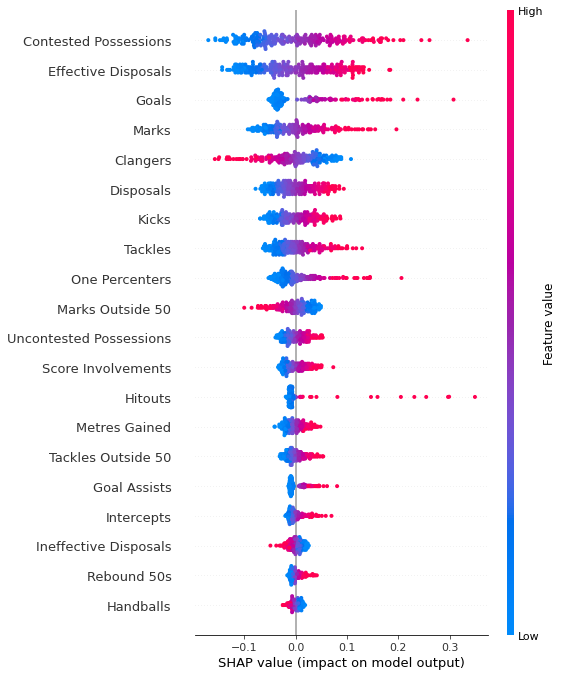

In [25]:
background_data = test_data.sample(n=250, random_state=0)

explainer = shap.KernelExplainer(
    fixed_mlp.predict, background_data[list(list(feature_importance_ordering.keys())[36])])

shap_values = explainer.shap_values(
    background_data[list(list(feature_importance_ordering.keys())[36])])

# Visualization
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])])

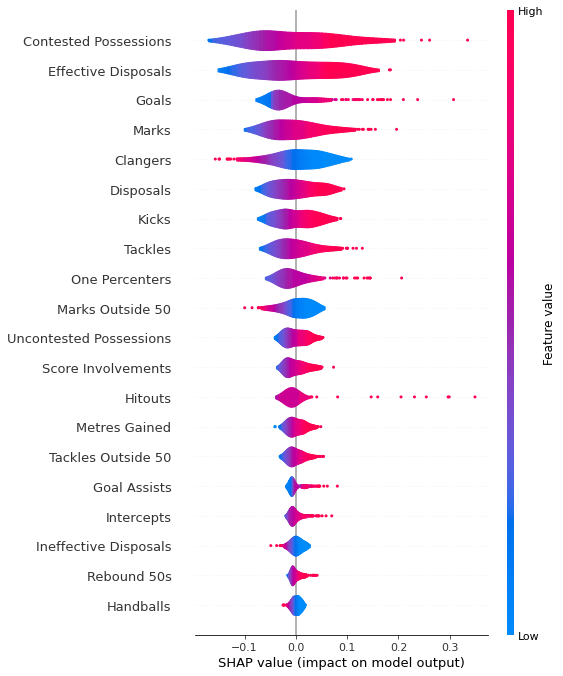

In [26]:
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])], plot_type='violin')

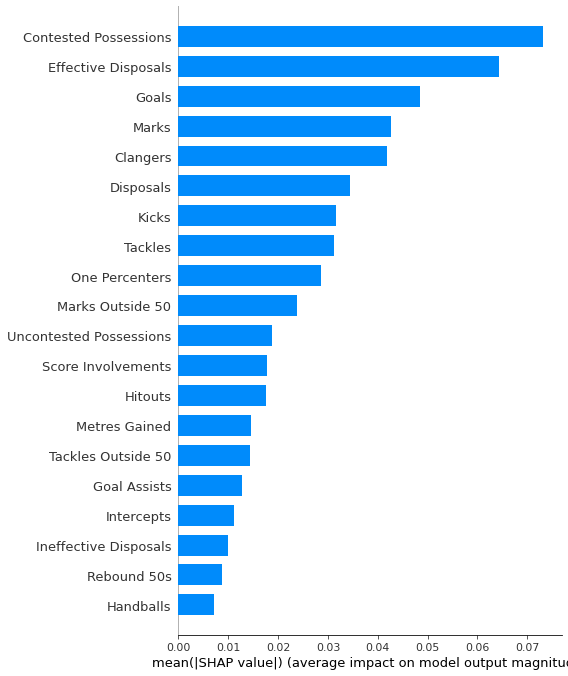

In [27]:
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])], plot_type='bar')

Player: Tom Ruggles


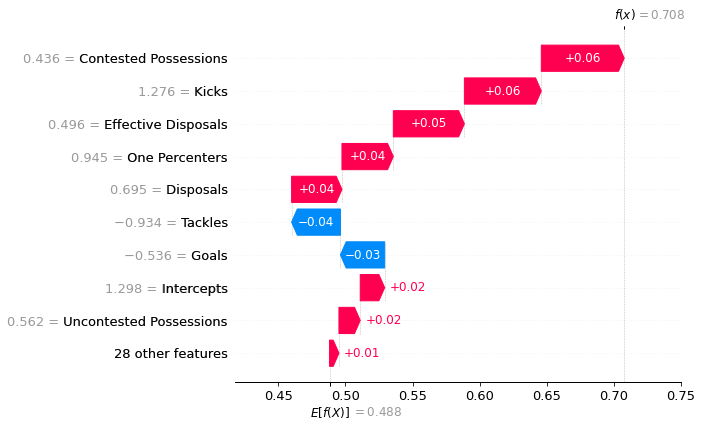

Player: Alan Toovey


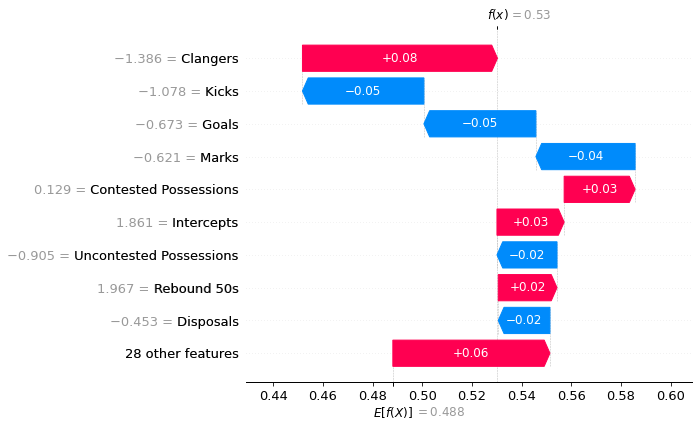

Player: Jason Johannisen


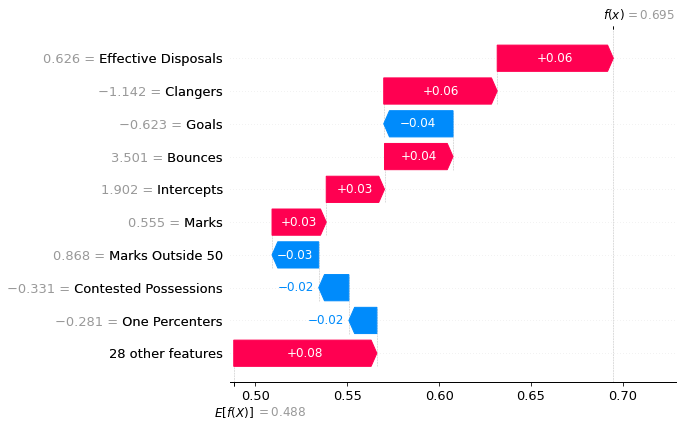

Player: Travis Boak


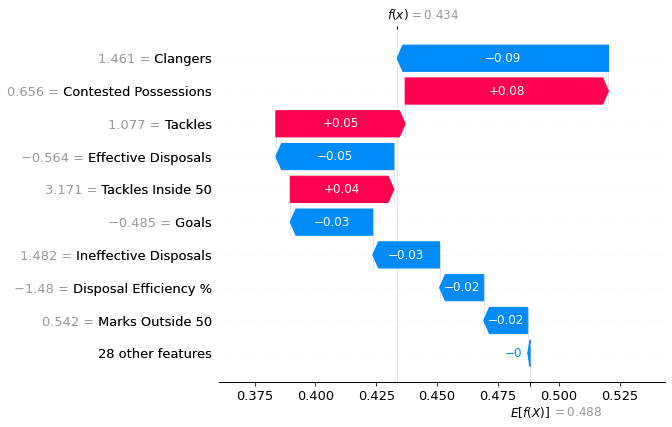

Player: Chad Wingard


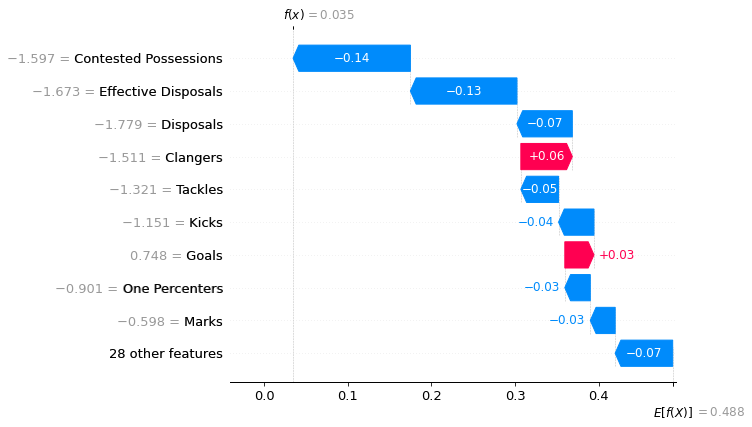

Player: Jake Kolodjashnij


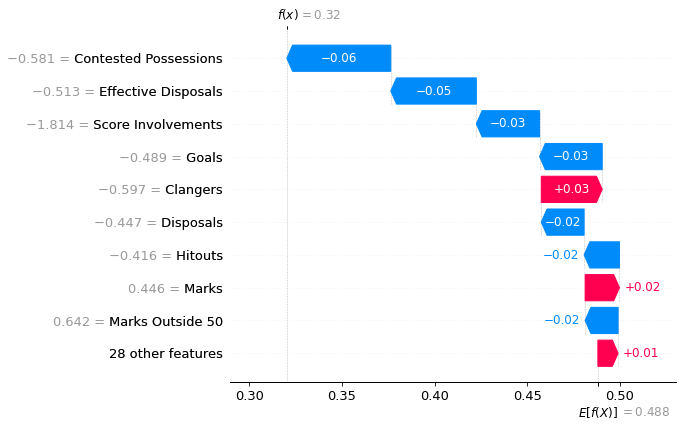

Player: Jamie Elliott


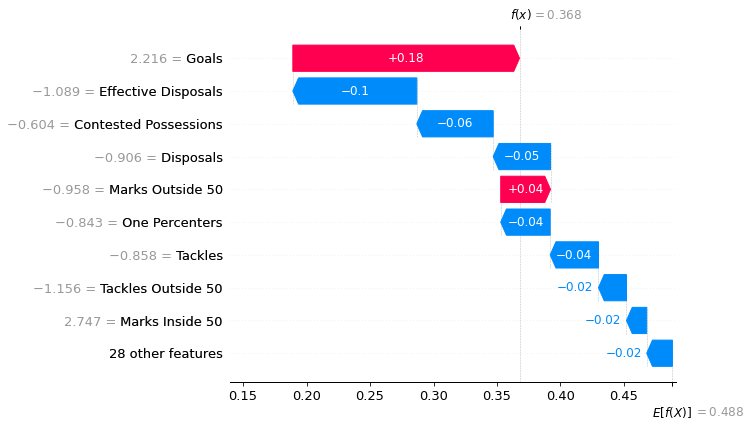

Player: Oliver Florent


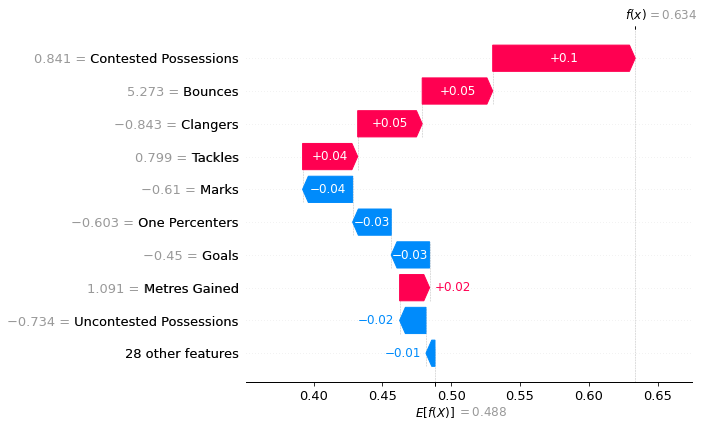

Player: Callum Mills


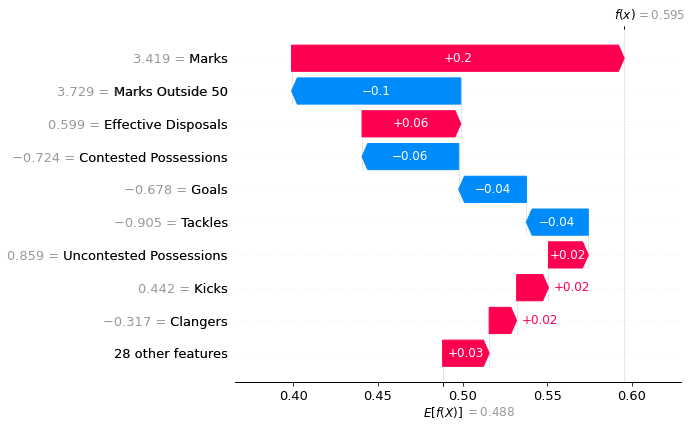

Player: Paul Seedsman


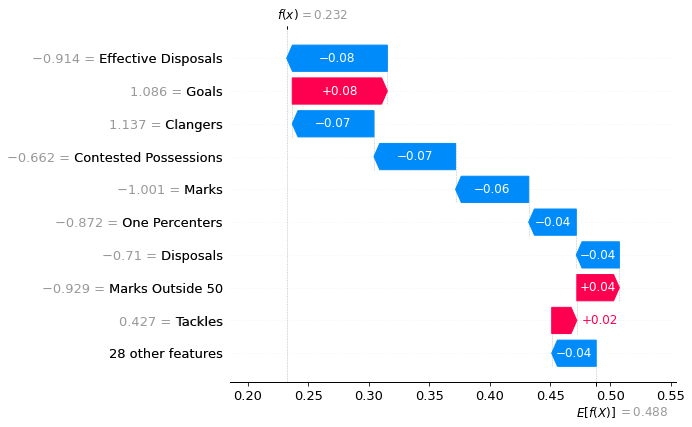

In [29]:
import shap
import matplotlib.pyplot as plt

# Assuming 'Player' is a column in your background_data DataFrame
for i in range(10):
    print(f'Player: {background_data.iloc[i]["Player"]}')

    # Generate SHAP waterfall plot for the i-th instance
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[i],
            base_values=explainer.expected_value,
            data=background_data[list(
                list(feature_importance_ordering.keys())[36])].iloc[i]
        )
    )